# 3.2 Operators based on second derivative

In the same way as we can detect edges by looking at the gradient (first-derivative) image, it is also possible to do that by analyzing the output of operators based on the second-derivative. 

First-derivative operators try to detect edges by looking for high magnitude values of such derivatives. Recall this figure shown in the previous section, illustrating two one-dimensional continuous functions $f(x)$ and their first derivatives.

<img src="./images/second_derivative_of_continuous_function.PNG" width="400">

We now add a third row (c) showing their second derivatives, and we can check how such values correspond to... **zero crossings!**. That is, a second derivative yields a zero-crossing at points where the gradient presents a maximum, so we could detect edges looking for those crossings.

Unfortunately, things get a little tricky when moving to a 2D space (like images). Why? because depending on the edge orientation, this zero-crossing may go almost unnoticed (see, for example, c):

<img src="./images/second_derivatives_of_2D_functions.PNG" width="500">

In this notebook we are going two explore two methods that face such issue and detect edges using the second derivative. These are:

- **Laplacian operator** (Section 3.2.1)
- **LoG operator** (Section 3.2.2)

Additionally, we will also take a look at a widely used algorithm that is a combination of different techniques: the **Canny algorithm** (Section 3.2.3).

## Problem context - Edge detection for medical images

Unfortunately, you were not accepted (yet!) by the researching team at *Hospital Clínico* because the obtained results in the previous notebook were not as good as expected. Anyway, they have shown you the algorithms that they are currently using so you can study it for future interviews. Let's have a look!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = './images/'

## 3.2.1 Laplace operator

Compared with the first derivative-based edge detectors such as the Sobel operator, the Laplacian operator may yield better results in edge localization, since it is:
- a linear operator,
- robust against noise,
- precise when localizing objects.

The idea behind it is to combine second derivatives in perpendicular directions. Thus, it is defined as:

$$ 
\nabla^2 f(i,j) =
\frac{\partial^2}{\partial x^2}f(i,j) + 
\frac{\partial^2}{\partial y^2}f(i,j)
$$

Note that, by definition, **it returns a scalar**, not a vector as in the gradient case. Indeed, the Laplacian is the trace of the *Hessian matrix*, which fully characterizes the second derivative of a function:

$$
H(f) =
\begin{bmatrix}
\frac{\partial f^2}{\partial x^2} & \frac{\partial}{\partial x}\frac{\partial f}{\partial y} \\
\frac{\partial f}{\partial y}\frac{\partial f}{\partial x} & \frac{\partial f^2}{\partial y^2}
\end{bmatrix}
$$


### Implementation
Now let's have a look to how the Laplacian operator is implemented.

1. First derivatives are considered (OpenCV uses Sobel but any is valid): $\\[5pt]$

$$\frac{\partial f(x,y)}{\partial x} = f_x(x,y) \approx G_R(i,j) = f(i+1,j) - f(i,j) \\[5pt]$$

$$\frac{\partial f(x,y)}{\partial y} = f_x(x,y) \approx G_C(i,j) = f(i,j+1) - f(i,j) \\[5pt]$$

2. Then, take second derivatives using them:

$$g = \frac{\partial f^2}{\partial x^2} = f_{xx}(x,y) \approx G_R(i,j) - G_R(i-1,j) = f(i+1,j) - 2f(i,j) + f(i-1,j) \\[5pt]$$

$$h = \frac{\partial f^2}{\partial y^2} = f_{yy}(x,y) \approx G_C(i,j) - G_C(i-1,j) = f(i,j+1) - 2f(i,j) + f(i,j-1) \\[10pt]$$

3. Finally, implementing it as a convolution with a certain kernel $L[F(i,j)] = F(i,j) \otimes L(i,j)$ and applying its distributive property:$\\[10pt]$
$$\underbrace{f \otimes (g + h)}_{\text{One convolution}} 
= 
\underbrace{(f \otimes g) + (f \otimes h)}_{\text{Two convolutions}}\\[10pt]$$

The good news is that we can obtain a kernel that carries out both convolutions at once!:

For example:

$$
g =
\begin{bmatrix}
0 & 0 & 0 \\
1 & -2 & 1 \\
0 & 0 & 0
\end{bmatrix}
\quad + \quad
h =
\begin{bmatrix}
0 & 1 & 0 \\
0 & -2 & 0 \\
0 & 1 & 0
\end{bmatrix}
\quad = \quad
L = g + h =
\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$

### Zero-crossing

Note that after applying that kernel, **it is needed an algorithm to detect zero-crossings** in order to return a binary image of edges. An example of a simple zero-crossing algorithm:

> 1. Select a small positive number (threshold) $th$.
> 2. A pixel is labelled as an edge if in the Laplacian image:
>    - its value is smaller than $-th$ and at least one of its neighbours is bigger that $th$, or
>    - its value is bigger than $th$ and at least one of its neighbours is smaller than $-th$.

### Limitations

Unfortunately, the Laplacian operator is very sensitive to noise, resulting in a poor edge detection. Solution: If the image is blurred using a Gaussian filter before applying the Laplace operator, we can partially solve the noise problem. In this case, it is called **LoG (Laplace of Gaussian)**.

## 3.2.2 LoG operator

So, the LoG operator first smoothes the image, and then applies the Laplacian operator, which applying the convolution properties gets to:

$$
\nabla^2[f(x,y)\otimes g_\sigma(x,y)] 
=
f(x,y) \otimes \nabla^2[g_\sigma(x,y)]
= f(x,y) \otimes LoG_\sigma(x,y)
$$

LoG is an isotropic operator, that is, it keeps radial symmetry. In this way, it is assumed that the covariance in both image dimensions is the same!

$$LoG_\sigma (x,y) = \frac{1}{\pi \sigma^4}
\left[ \frac{x^2+y^2}{2 \sigma^2} -1 \right] \exp^{-\frac{x^2+y^2}{2 \sigma^2}}
=
\left[ \frac{r^2}{2 \sigma^2} -1 \right] \exp^{-\frac{r^2}{2 \sigma^2}}
= LoG_\sigma(r^2)
$$

**Let's print the LoG operator!**

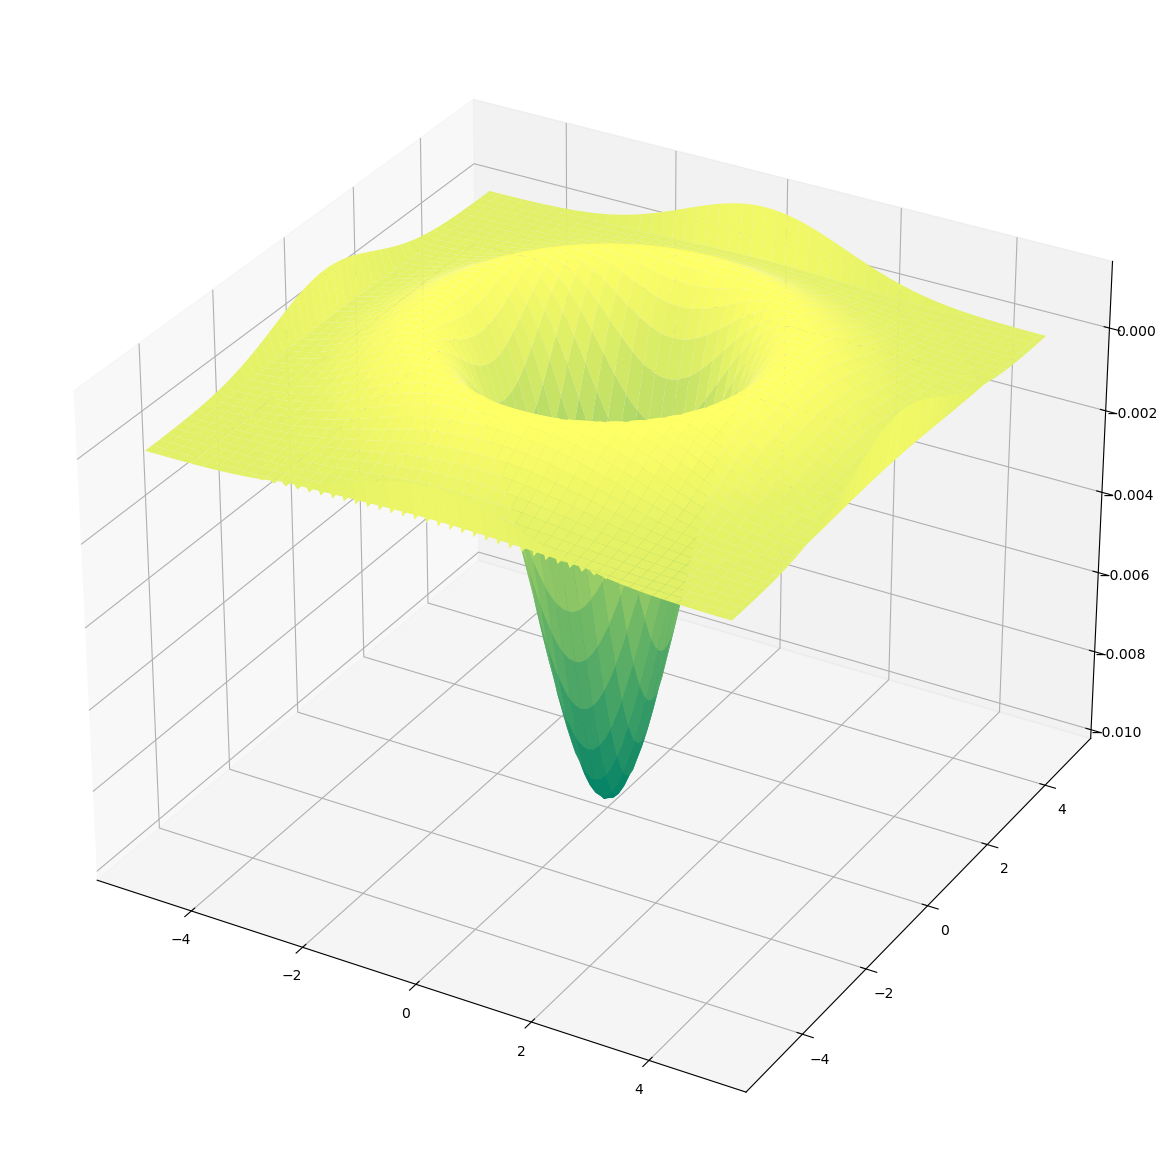

In [3]:
# Gauss filter
v = np.arange(-5,5,0.1)
X, Y = np.meshgrid(v,v)
covar = np.array([[2, 0],[0, 2]]) ## Assuming no correlation between X and Y
gauss_filter = np.exp(-0.5*(X**2/covar[0][0]+Y**2/covar[1][1])) 

# Laplace filter
laplace_filter = np.array(([[0,1,0],[1,-4,1],[0,1,0]]), dtype="float")

# LoG operator
LoG = cv2.filter2D(gauss_filter, -1, laplace_filter) # Convolve the two filters

# Plot it!
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # Create a 3D axis
ax.plot_surface(X, Y, LoG, cmap='summer', edgecolor='none')

As a side note, the LoG is not separable, but it can be implemented as **DoG (Difference of Gaussians)**, a sum of separable operators, reducing its complexity from $O(N^2)$ to $O(4N)$:

$$
DoG_{\sigma_1\sigma_2}(x,y) = 
g_{\sigma_1}(x,y) - g_{\sigma_2}(x,y) =
g_{\sigma_1}(x)g_{\sigma_1}(y) - g_{\sigma_2}(x) g_{\sigma_2}(y)
$$

Giving the ration $\sigma_1 / \sigma_2 = 1.6$ the best approximation of LoG. This complexity reduction approach is employed in the SIFT keypoint detector, as we will see in following notebooks.

### Limitations

- It is computationally costly.
- It doesn't provide any information about edge orientations.
- The output contains negative and non-integer values, so for display purposes the image should be normalized to the range 0-255.
- It is needed a zero-crossing method.
- It tends to round object corners (more heavily as $\sigma$ grows).

### Experiencing Laplacian and LoG operators 

Now that we are almost experts in the Laplacian and LoG operators, let's play a bit with them!

### **<span style="color:green"><b><i>ASSIGNMENT 1a: Applying Gaussian smoothing</i></b></span>**

First, complete the function `gaussian_smoothing()` that blurs an image using a Gaussian filter. Then, normalizes it and returns the resulting image.

In [4]:
# ASSIGNMENT 1a SOLUTION
# Implement a function that blurres an input image using a Gaussian filter and then normalizes it.
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.   
    
        Args:
            image: Input image to be binarized
            sigma: Standard deviation of the Gaussian distribution
            w_kernel: Kernel aperture size
                    
        Returns: 
            binarized: Blurred image
    """   
    # Define 1D kernel
    ax = np.linspace(-(w_kernel - 1) / 2., (w_kernel - 1) / 2., w_kernel)
    gauss_1D = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    gauss_1D = gauss_1D / np.sum(gauss_1D)  # Normalize 1D kernel
    
    # Apply distributive property of convolution
    gauss_2D = np.outer(gauss_1D, gauss_1D)
    blurred = cv2.filter2D(image, -1, gauss_2D) 
    # Blur image
    blurred = cv2.GaussianBlur(image, (w_kernel, w_kernel), sigma)
    # Normalize to [0 254] values
    blurred = cv2.normalize(blurred, None, alpha=0, beta=254, norm_type=cv2.NORM_MINMAX)                        

    return blurred

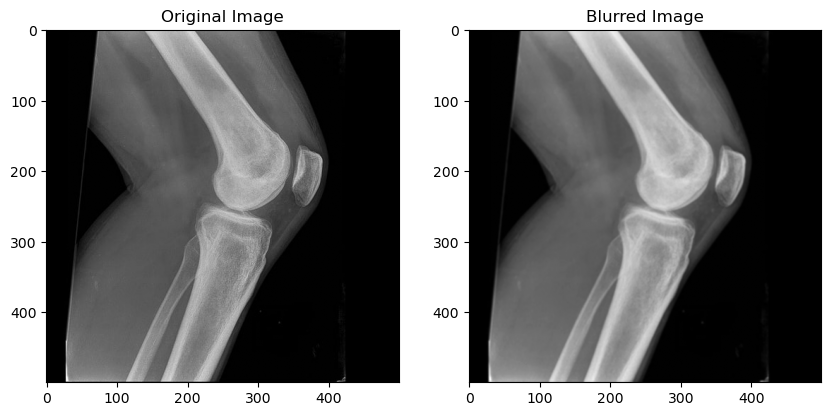

In [6]:
# call the gaussian_smoothing function
image = cv2.imread(images_path + 'medical_2.jpg', cv2.IMREAD_GRAYSCALE)
blurred = gaussian_smoothing(image, sigma=1, w_kernel=5)    
plt.figure(figsize=(10,10))
plt.subplot(1,2,1), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(1,2,2), plt.imshow(blurred, cmap='gray'),
plt.title('Blurred Image')
plt.show()


Now, we are going to see the differences between the Laplace and LoG operators.

### **<span style="color:green"><b><i>ASSIGNMENT 1b: Detecting edges with Laplace and LoG</i></b></span>**

Complete `laplace_testing()` that applies the Laplacian operator to the input image and to a blurred version of the input image (use the previously implemented function to smooth it). Display both images along with the original one in a 1x3 plot. Use as inputs: an image, the size of the Laplacian filter (should be odd), and the parameters of the Gaussian filter.

Note that it would possible to reduce the computation time if LoG would be precomputed. This is convolving Laplace and Gaussian filters instead of applying them separatelly.

*Tip: OpenCV defines Laplace operator as [cv2.Laplacian()](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html)*

In [ ]:
# ASSIGNMENT 1b 
# Implement a function that applies the Laplacian operator to the input image and to a blurred version of it. 
# Display a 1x3 plot with the original image and the two resulting edge images.
# Inputs: image, size of the Laplacian kernel, sigma and size of the Gaussian kernel
def laplace_testing(image, size_Laplacian, sigma, w_gaussian):
    """ Apply Laplacian and Log operators to an image.   
    
        Args:
            image: Input image to be binarized
            size_Laplacian: size of Laplacian kernel (odd)
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
    """
    
    # Blur image
    
    
    # Apply Laplacian to original image
    
    
    # Aplay Laplacian to blurred image
    
    
    # Show initial image
    
    
    # Show laplacian
    
    
    # Show LoG
    

In [8]:
# ASSIGNMENT 1b SOLUTION
# Implement a function that applies the Laplacian operator to the input image and to a blurred version of it. 
# Display a 1x3 plot with the original image and the two resulting edge images.
# Inputs: image, size of the Laplacian kernel, sigma and size of the Gaussian kernel
def laplace_testing(image, size_Laplacian, sigma, w_gaussian):
    """ Apply Laplacian and Log operators to an image.   
    
        Args:
            image: Input image to be binarized
            size_Laplacian: size of Laplacian kernel (odd)
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
    """
    
    # Blur image
    blurred = gaussian_smoothing(image, sigma=1, w_kernel=5)    

    
    # Apply Laplacian to original image
    laplacian_original = cv2.Laplacian(image, cv2.CV_64F, ksize=size_Laplacian)

    # Apply Laplacian to blurred image
    laplacian_blurred = cv2.Laplacian(blurred, cv2.CV_64F, ksize=size_Laplacian)
    
    
    # Show initial image
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1), plt.imshow(image, cmap='gray'), plt.title('Original Image')
    plt.show()
    # Show laplacian
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1), plt.imshow(laplacian_original, cmap='gray'), plt.title('Laplacian on Original')
    plt.show()  
    
    # Show LoG
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1), plt.imshow(laplacian_blurred,
                cmap='gray'), plt.title('Laplacian on Blurred')
    plt.show()
    

It is time to try this method to our medical images and play with interactive parameters.$\\[5pt]$      

In [9]:
# Read an image
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Interact with the parameters!
interact(laplace_testing, image=fixed(image), size_Laplacian=(1,7,2), sigma=(1,3,0.1), w_gaussian=(1,3,1))

interactive(children=(IntSlider(value=3, description='size_Laplacian', max=7, min=1, step=2), FloatSlider(valu…

<function __main__.laplace_testing(image, size_Laplacian, sigma, w_gaussian)>

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now, **answer the following questions**:

- Can be the Laplacian applied without a previous blurring?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- What would be needed for obtaining the edges from those images?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

## 3.2.3 The Canny algorithm

The Canny edge detector<sup>[[1]](#cite1)</sup> is an algorithm that applies the DroG operator, non-maxima suppression and hysteresis for edge detection in images. It was designed to be a good detector, yield a good localization, and to provide a single response!

This algorithm consists of the following steps:

1. *Noise filtering*. Filter out any noise using a Gaussian filter.$\\[5pt]$

2. *Obtain the gradient image*. Apply the DroG operator.$\\[5pt]$

3. *Non-maximum suppression* is applied. This removes pixels that are not considered to be part of an edge. Typically, the gradient image obtained after using DroG presents thick edges. The idea is to keep only those pixels that are maximum within their neighborhood in the gradient direction, suppressing the rest of them. Hence, only thin lines (candidate edges) will remain. For that:

     - We consider 4 main directions: $[0,45]$, $[45,90]$, $[90,135]$, $[135,180]$. The gradient angle $\theta[i,j]$ is approximated by where it lays. 
     - We check the $G[i,j]$ at the three points along the selected direction, and pick the maximum. This way we have a single response at each edge.

<img src="./images/canny_nonmaxima.png" width="800">

4. *Hysteresis*: The final step. Canny uses two thresholds (upper and lower) to determine edge pixels:

    - If the grey level of a candidate pixel of the gradient image is higher than the upper threshold, the pixel is accepted as an edge.
    - If the grey level of a candidate pixel of the gradient image is below the lower threshold, then it is rejected.
    - If the grey level of a candidate pixel of the gradient image is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold and rejected otherwise.
   
<img src="./images/hysteresis.png" width="800">

The algorithm can be repeated with different level of smoothing (changing the sigma of the DroG operator). Different sigma produces edges at different spatial features.

### **<span style="color:green"><b><i>ASSIGNMENT 2: The enormously popular Canny algorithm</i></b></span>**

Complete `canny_testing()`, which applies the Canny algorithm to an image and to a blurred version of it *(note that OpenCV Canny's implementation does not apply Gaussian blurring)*. Then both are displayed along the original image. It takes an image, both lower and upper Canny thresholds, and the parameters of the Gaussian filter as input.

*Note: use `gaussian_smoothing` to blur the image.*

*Tip: OpenCV defines the Canny algorithm as [cv2.Canny()](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny)*

In [ ]:
# ASSIGNMENT 2
# Implement a function that applies the Canny operator to an input image and to a blurred version of it. 
# Display a 1x3 plot with the original image and the two resulting edge images.
# Inputs: image, size of the Laplacian kernel, sigma and size of the Gaussian kernel
def canny_testing(image, lower_threshold, upper_threshold, sigma, w_gaussian):
    """ Apply Canny algorithm to an image.   
    
        Args:
            image: Input image to be binarized
            lower_threshold: bottom value for hysteresis
            upper_threshold: top value for hysteresis
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
    """  
    
    # Blur image
    
    
    # Apply Canny to original image
    
    
    # Apply Canny to blurred image
    

    # Show initial image
    
    
    # Show Canny without blurring
    
    
    # Show Canny with blurring
    

In [10]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

def canny_testing(image, lower_threshold, upper_threshold, sigma, w_gaussian):
    """
    Apply the Canny edge detection algorithm to an image,
    with and without Gaussian blurring, and display results.

    Args:
        image (numpy.ndarray): Input grayscale or color image.
        lower_threshold (int): Lower threshold for Canny hysteresis.
        upper_threshold (int): Upper threshold for Canny hysteresis.
        sigma (float): Standard deviation of the Gaussian distribution.
        w_gaussian (int): Gaussian kernel size (must be odd).

    Returns:
        edges_noisy (numpy.ndarray): Edges detected without blurring.
        edges_denoised (numpy.ndarray): Edges detected after Gaussian blur.
    """
    
    # Ensure Gaussian kernel size is odd
    if w_gaussian % 2 == 0:
        w_gaussian += 1
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (w_gaussian, w_gaussian), sigma)
    
    # Apply Canny edge detection to original (noisy) image
    edges_noisy = cv2.Canny(image, lower_threshold, upper_threshold)
    
    # Apply Canny edge detection to blurred (denoised) image
    edges_denoised = cv2.Canny(blurred, lower_threshold, upper_threshold)
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    if len(image.shape) == 3:  # Color image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:  # Grayscale image
        plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    # Canny without blurring
    plt.subplot(1, 3, 2)
    plt.imshow(edges_noisy, cmap='gray')
    plt.title("Canny (Noisy)")
    plt.axis("off")
    
    # Canny with Gaussian blurring
    plt.subplot(1, 3, 3)
    plt.imshow(edges_denoised, cmap='gray')
    plt.title("Canny (Denoised)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return edges_noisy, edges_denoised


Among the multiple parameters of this algorithm, it is interesting to check its performance with different levels of smoothing (changing the sigma of the DroG operator). Different sigma produces edges at different spatial features. **Try the effect of this and other parameters** playing with interactive parameters.$\\[5pt]$      

In [11]:
# Read an image
images_path = './images/'

# Check if image exists and load it
try:
    image = cv2.imread(images_path + 'medical_2.jpg', 0)
    if image is None:
        print("Warning: Could not load image. Please check the file path.")
        # Create a sample image for testing
        image = np.random.randint(0, 255, (200, 200), dtype=np.uint8)
        print("Using a sample random image for demonstration.")
except:
    print("Error loading image. Using sample image.")
    image = np.random.randint(0, 255, (200, 200), dtype=np.uint8)

# Interact with the parameters
interact(canny_testing, 
         image=fixed(image), 
         lower_threshold=(0, 255, 10), 
         upper_threshold=(0, 255, 10), 
         sigma=(0.1, 5.0, 0.1), 
         w_gaussian=(1, 15, 2))  # Step by 2 to ensure odd numbers

interactive(children=(IntSlider(value=120, description='lower_threshold', max=255, step=10), IntSlider(value=1…

<function __main__.canny_testing(image, lower_threshold, upper_threshold, sigma, w_gaussian)>

If you don't want to interact with the code, you can call the function directly as,

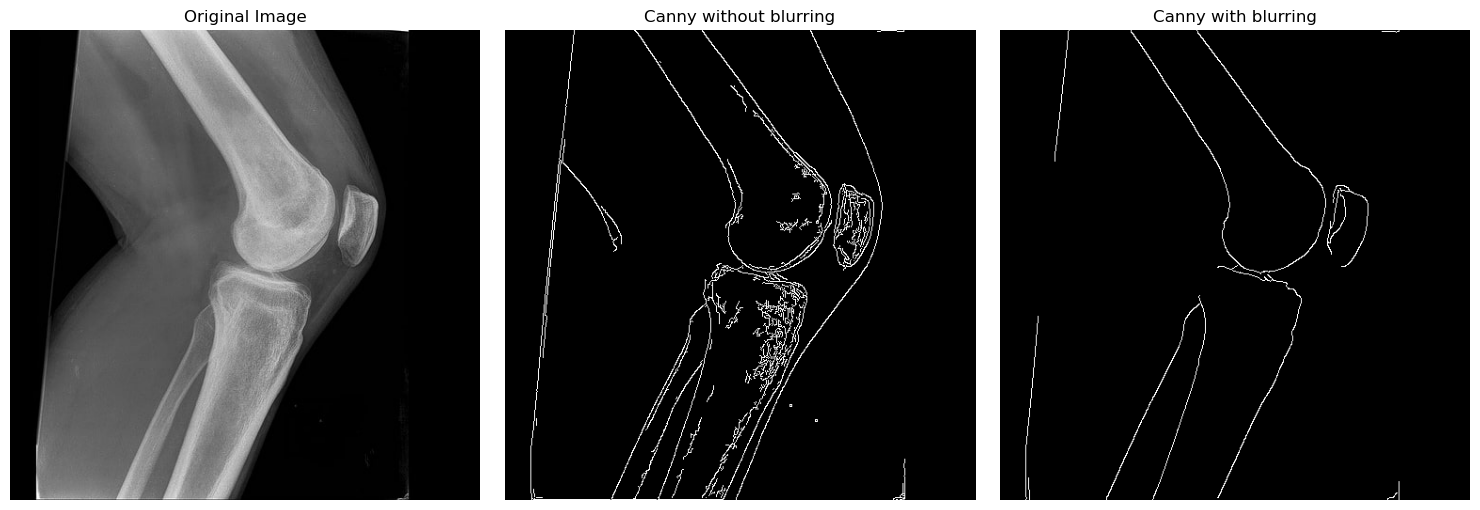

In [8]:
import cv2

# Load an example image (adjust the path if needed)
example_path = "./images/medical_2.jpg"
example_img = cv2.imread(example_path)

if example_img is None:
    raise FileNotFoundError(f"Could not load sample image at {example_path}")

# Static Canny test
canny_testing(
    image=example_img,
    lower_threshold=60,
    upper_threshold=180,
    sigma=1.2,
    w_gaussian=5,
)


For a brief recap of edge detection using the Canny algorithm, visit this link:
https://machinelearningmastery.com/opencv_edges_and_corners/


### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Now, **answer following questions**:

- Can be Canny applied without a previous blurring?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- What is a *good* value for both thresholds?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  
    
- Now that you have tried a good number of edge detection methods, **which one is your favorite, and why?**

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  

## OPTIONAL: Edge Detection from Live Images

In [ ]:
# Read video from my webcam, take each frame and apply the Canny operator
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Apply Canny edge detection with Gaussian blurring
    edges_noisy, edges_denoised = canny_testing(
        image=frame,
        lower_threshold=60,
        upper_threshold=180,
        sigma=1.2,
        w_gaussian=5,
    )
    
    # Display the resulting frames
    cv2.imshow('Original', frame)
    cv2.imshow('Canny Noisy', edges_noisy)
    cv2.imshow('Canny Denoised', edges_denoised)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Can you process one frame every second? This will reduce burden on your computer resources.

## Conclusion

Terrific! You finished this notebook, that includes information about:

- Laplace and LoG operators and the importance of smoothing.
- how to use the Canny algorithm, and how it is implemented.

## Extra

The Canny algorithm is a very known algorithm in the field, it is used in a lot of current technologies. Although it still gets very good results, the original paper was published in 1986 by John Canny<sup>[[1]](#cite1)</sup>.

## References

<a name="myfootnote1">[1]</a>: CANNY, John. [A computational approach to edge detection.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwiU9uyiganoAhWNDWMBHducCvsQFjAJegQIBhAB&url=http%3A%2F%2Fciteseerx.ist.psu.edu%2Fviewdoc%2Fdownload%3Fdoi%3D10.1.1.420.3300%26rep%3Drep1%26type%3Dpdf&usg=AOvVaw3tsKoxnc3qnS7bji3HmvQc). IEEE Transactions on pattern analysis and machine intelligence, 1986, no 6, p. 679-698.